# CLUSTERING D'ARTICLES

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les données en utilisant pandas
df1 = pd.read_csv("preprocessed_df.csv", encoding = "ISO-8859-1")
df = df1.copy()

In [13]:
df1.head()

,article
0,"['musician', 'tackle', 'u', 'red', 'tape', 'mu..."
1,"['u2s', 'desire', 'number', 'one', 'u2', 'thre..."
2,"['rocker', 'doherty', 'onstage', 'fight', 'roc..."
3,"['snicket', 'top', 'u', 'box', 'office', 'char..."
4,"['ocean', 'twelve', 'raid', 'box', 'office', '..."


### Analyse Statistiques

Analyse de la fréquence des termes

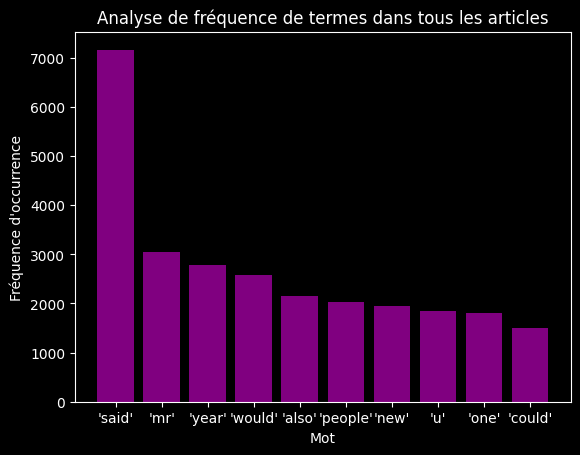

In [14]:
# Concaténation de toutes les listes de tokens dans une seule liste
from collections import Counter
text = ' '.join(df1['article'].tolist())

# Séparation des mots à partir de la liste
word_list = text.split(', ')

# Compter la fréquence d'occurrence de chaque mot
frequency = Counter(word_list)

# Trier les mots en fonction de leur fréquence d'occurrence
frequency = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))

# Afficher les 10 mots les plus fréquents
top_10_words = dict(list(frequency.items())[:10])

# Visualisation des résultats
plt.bar(top_10_words.keys(), top_10_words.values(), color='purple')
plt.xlabel('Mot')
plt.ylabel('Fréquence d\'occurrence')
plt.title('Analyse de fréquence de termes dans tous les articles')
plt.show()

Analyse de la distribution des mots

### Clustering

Recherche du meilleur nombre de clusters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


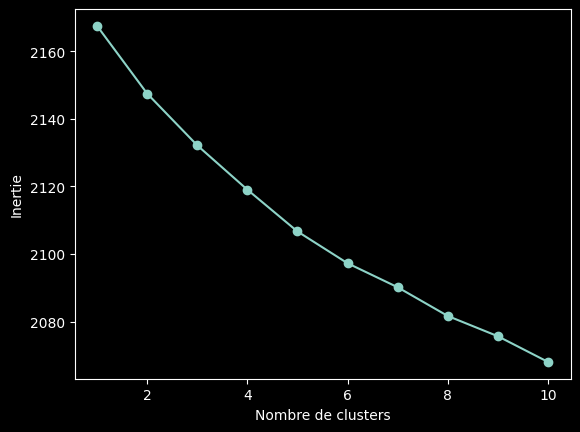

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Créer un vecteur de fonctionnalités
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['article'])

# Calculer l'inertie pour différents nombres de clusters
inertias = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Tracer l'inertie en fonction du nombre de clusters
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.show()

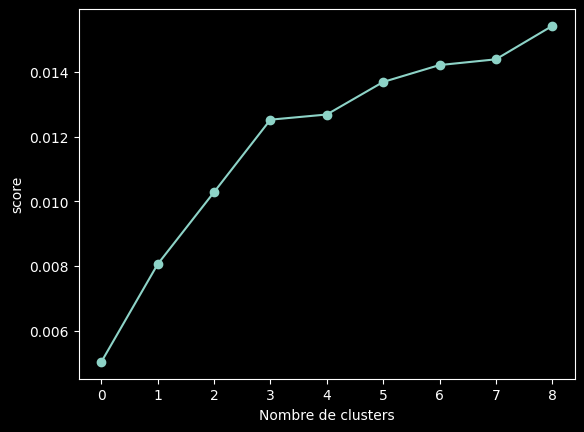

Le meilleur nombre de clusters est : 10


In [16]:
# Utilisation de la méthode silhouette_score pour trouver le meilleur nombre de cluster 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['article'])

X1 = X

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    score = silhouette_score(X, kmeans.labels_)
    scores.append(score)

# Tracer l'inertie en fonction du nombre de clusters
plt.plot(scores, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("score")
plt.show()

best_k = np.argmax(scores) + 2
print("Le meilleur nombre de clusters est :", best_k)

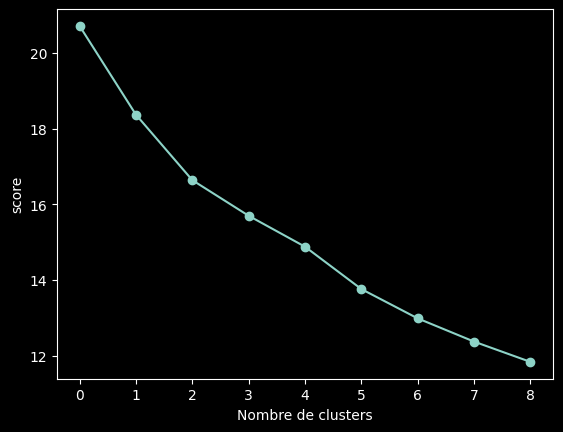

Le meilleur nombre de clusters est : 2


In [17]:
# Utilisation de la méthode de Calinski - Harabasz pour déterminer le meilleur nombre de cluster
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import calinski_harabasz_score
from scipy.sparse import csr_matrix

X_ = csr_matrix(X)
X_ = X.toarray()

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    score = calinski_harabasz_score(X_, kmeans.labels_)
    scores.append(score)

# Tracer l'inertie en fonction du nombre de clusters
plt.plot(scores, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("score")
plt.show()

best_k = np.argmax(scores) + 2
print("Le meilleur nombre de clusters est :", best_k)

In [18]:
#Méthodedu coude pour trouver le meilleur nombre de clusters
from sklearn.cluster import KMeans
import numpy as np

X2 = X1.copy()
k_max = 10

noise = np.zeros(k_max)
for k in range(1, k_max + 1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X2)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    distances = np.linalg.norm(X - centers[labels], axis=1)
    noise[k-1] = distances.sum()

best_k = np.argmin(noise) + 1
print(best_k)

10


On définit le nombre de cluster optimal trouvé à 10.

In [19]:
k_best = 10

In [20]:
# Clustering avec KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

df1 = df.copy()

# Créer un pipeline de traitement des données
vectorizer = TfidfVectorizer()
kmeans = KMeans(n_clusters=k_best)
pipeline = Pipeline([("vectorizer", vectorizer), ("kmeans", kmeans)])

# Entraîner le modèle
X = df1['article']
pipeline.fit(X)
df1["cluster"] = kmeans.labels_

# Extraire les centres des clusters
cluster_centers = kmeans.cluster_centers_

# Déterminer le vocabulaire associé à chaque cluster
vocabulary = vectorizer.vocabulary_

# Fonction pour trouver les mots les plus pertinents pour chaque cluster
def find_top_words(cluster_index, n_words=10):
    cluster = cluster_centers[cluster_index]
    sorted_indexes = np.argsort(-cluster)
    words = [word for index in sorted_indexes[:n_words] for word, weight in vocabulary.items() if weight == index]
    return words

In [21]:
#On définit le topic du cluster en fonction des mots qui le composent.
import spacy
from scipy import spatial

nlp = spacy.load("en_core_web_md")

# Define the list of topics
topics = ["economy", "informatics", "sport", "politics", "Art", "Music", "Cinema", "History", "Health", "Security", "Media", "entertainment", "Gastronomy", "Animals", "Fashion"]

def topicFromWords(words):

    # Create embeddings for the words
    word_embeddings = [nlp(word).vector for word in words]

    # Create embeddings for the topics
    topic_embeddings = [nlp(topic).vector for topic in topics]

    # Find the most similar topic
    similarities = [spatial.distance.cosine(sum(word_embeddings)/len(word_embeddings), topic_embedding) for topic_embedding in topic_embeddings]
    most_similar_topic = topics[similarities.index(min(similarities))]

    # Print the most similar topic
    return most_similar_topic

In [22]:
#Donne pour chaque cluster son topic
clusters_topic = {}
for i in range(k_best):
    clusters_topic[i] = topicFromWords(find_top_words(i))
    print(clusters_topic[i])

df1["topic"] = df1["cluster"].apply(lambda x: clusters_topic[x])

sport
economy
entertainment
politics
sport
Cinema
sport
economy
informatics
entertainment


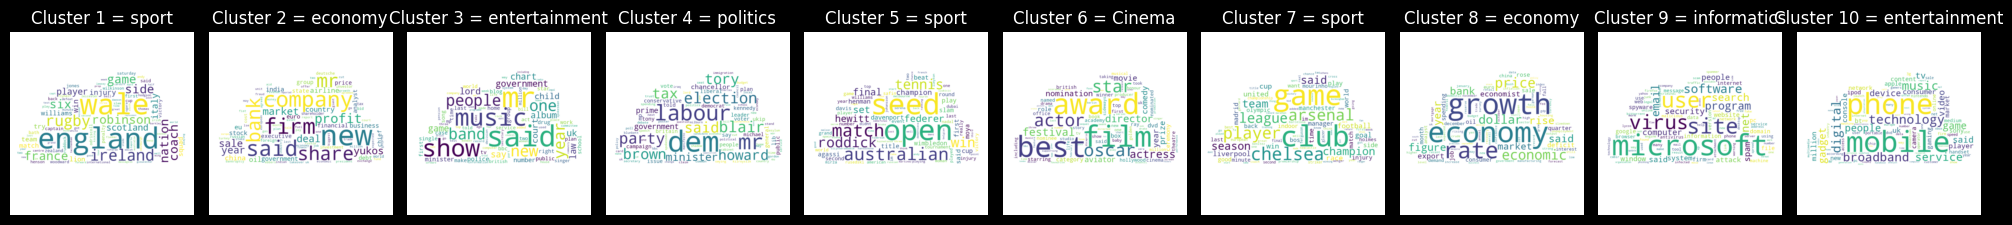

Cluster 1
Top words: ['england', 'wale', 'ireland', 'rugby', 'robinson', 'game', 'france', 'nation', 'six', 'coach']


Cluster 2
Top words: ['company', 'said', 'firm', 'share', 'mr', 'bank', 'profit', 'market', 'yukos', 'sale']


Cluster 3
Top words: ['said', 'mr', 'music', 'show', 'would', 'people', 'year', 'new', 'band', 'one']


Cluster 4
Top words: ['mr', 'labour', 'election', 'party', 'blair', 'tory', 'brown', 'said', 'tax', 'howard']


Cluster 5
Top words: ['open', 'seed', 'australian', 'match', 'roddick', 'tennis', '63', 'win', 'federer', 'set']


Cluster 6
Top words: ['film', 'award', 'best', 'oscar', 'actor', 'star', 'festival', 'actress', 'director', 'nomination']


Cluster 7
Top words: ['club', 'game', 'chelsea', 'player', 'arsenal', 'league', 'champion', 'team', 'season', 'said']


Cluster 8
Top words: ['economy', 'growth', 'rate', 'price', 'economic', 'dollar', 'figure', 'said', 'rise', 'bank']


Cluster 9
Top words: ['user', 'site', 'virus', 'software', 'program', 'email'

In [23]:
#Nuage de mots

from wordcloud import WordCloud
from PIL import Image

#On charge une image de nuage
mask = np.array(Image.open("cloud.png"))
mask[mask == 1] = 255

#On créer le nuage de mots pour un cluster donné
def plot_wordcloud(cluster_index, n_words=100):
    words = find_top_words(cluster_index, n_words)
    text = " ".join(words)
    wordcloud = WordCloud(background_color = 'white', width=800, height=400, random_state=21, max_font_size=110,  mask = mask).generate(text)
    return wordcloud

#On créer le nuage de mots pour chaque cluster
wordclouds = [plot_wordcloud(i) for i in range(kmeans.n_clusters)]

# On affiche tous les nuages de mots en utilisant matplotlib
plt.figure(figsize=(20, 12))
for i, wordcloud in enumerate(wordclouds):
    plt.subplot(1, kmeans.n_clusters, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster " + str(i + 1) + " = " + topicFromWords(find_top_words(i)))
plt.tight_layout()
plt.show()

# Affichage des mots les plus pertinents pour chaque cluster
for i in range(kmeans.n_clusters):
    print("Cluster", i + 1)
    print("Top words:", find_top_words(i))
    print("\n")

On obient des clusters très précis. Par exemple, les deux premiers clusters sont sur des sujets sportifs, mais traitent de sport différents. 
On pourrait réunir plusieurs clusters entre eux, 5 clusters semble suffisant pour réunir tous les sujets. On change donc le nombre de cluster optimal par 5.

sport
economy
informatics
Cinema
politics


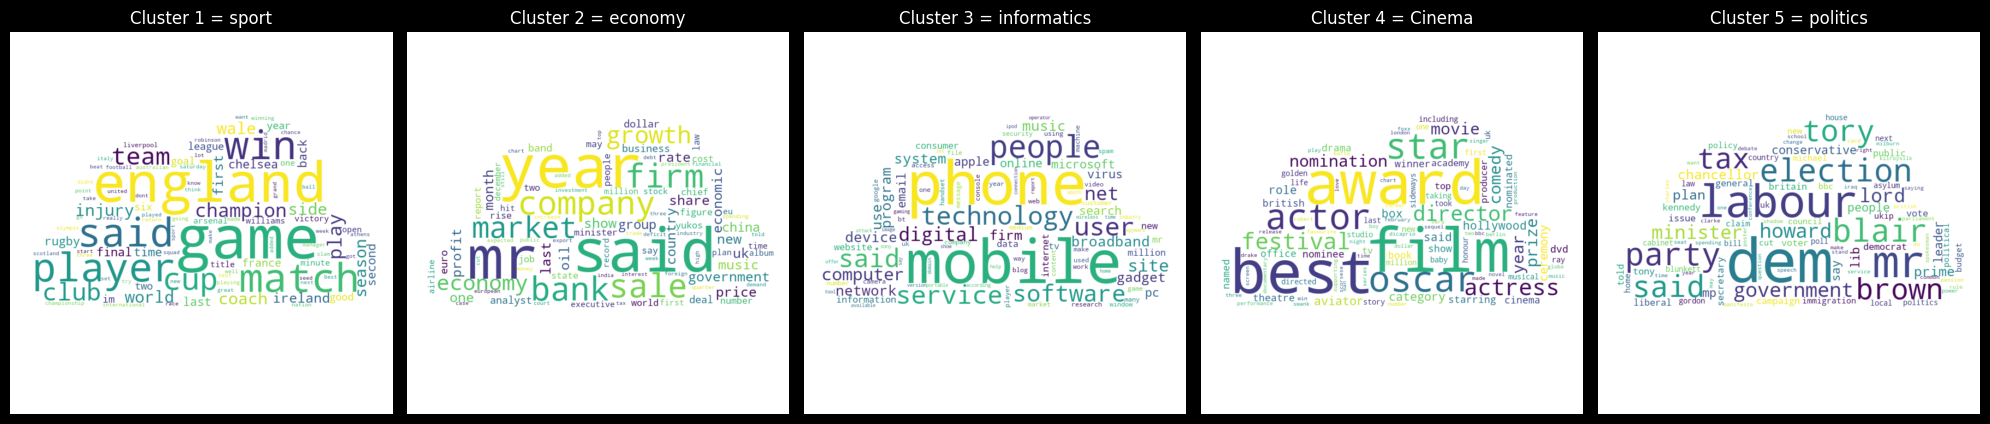

Cluster 1
Top words: ['game', 'england', 'player', 'said', 'win', 'match', 'cup', 'club', 'team', 'champion']


Cluster 2
Top words: ['said', 'year', 'mr', 'company', 'sale', 'firm', 'bank', 'market', 'growth', 'economy']


Cluster 3
Top words: ['mobile', 'phone', 'people', 'technology', 'user', 'said', 'service', 'software', 'digital', 'net']


Cluster 4
Top words: ['film', 'award', 'best', 'oscar', 'actor', 'star', 'festival', 'actress', 'director', 'nomination']


Cluster 5
Top words: ['mr', 'labour', 'election', 'party', 'blair', 'tory', 'said', 'brown', 'would', 'tax']




In [24]:
k_best = 5
#Clustering avec KMeans

# Créer un pipeline de traitement des données
vectorizer = TfidfVectorizer()
kmeans = KMeans(n_clusters=k_best)
pipeline = Pipeline([("vectorizer", vectorizer), ("kmeans", kmeans)])

# Entraîner le modèle
X = df['article']
pipeline.fit(X)
df["cluster"] = kmeans.labels_

# Extraire les centres des clusters
cluster_centers = kmeans.cluster_centers_

# Déterminer le vocabulaire associé à chaque cluster
vocabulary = vectorizer.vocabulary_

clusters_topic = {}
for i in range(k_best):
    clusters_topic[i] = topicFromWords(find_top_words(i))
    print(clusters_topic[i])

df["topic"] = df["cluster"].apply(lambda x: clusters_topic[x])

# Créer un nuage de mots pour chaque cluster
wordclouds = [plot_wordcloud(i) for i in range(kmeans.n_clusters)]

# Afficher tous les nuages de mots en utilisant matplotlib
plt.figure(figsize=(20, 12))
for i, wordcloud in enumerate(wordclouds):
    plt.subplot(1, kmeans.n_clusters, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster " + str(i + 1) + " = " + topicFromWords(find_top_words(i)))
plt.tight_layout()
plt.show()

# Afficher les mots les plus pertinents pour chaque cluster
for i in range(kmeans.n_clusters):
    print("Cluster", i + 1)
    print("Top words:", find_top_words(i))
    print("\n")

In [25]:
df.head()

,article,cluster,topic
0,"['musician', 'tackle', 'u', 'red', 'tape', 'mu...",1,economy
1,"['u2s', 'desire', 'number', 'one', 'u2', 'thre...",1,economy
2,"['rocker', 'doherty', 'onstage', 'fight', 'roc...",1,economy
3,"['snicket', 'top', 'u', 'box', 'office', 'char...",3,Cinema
4,"['ocean', 'twelve', 'raid', 'box', 'office', '...",3,Cinema


##### Diagramme de Venn pour représenter les intersections entre chaque couple de cluster.

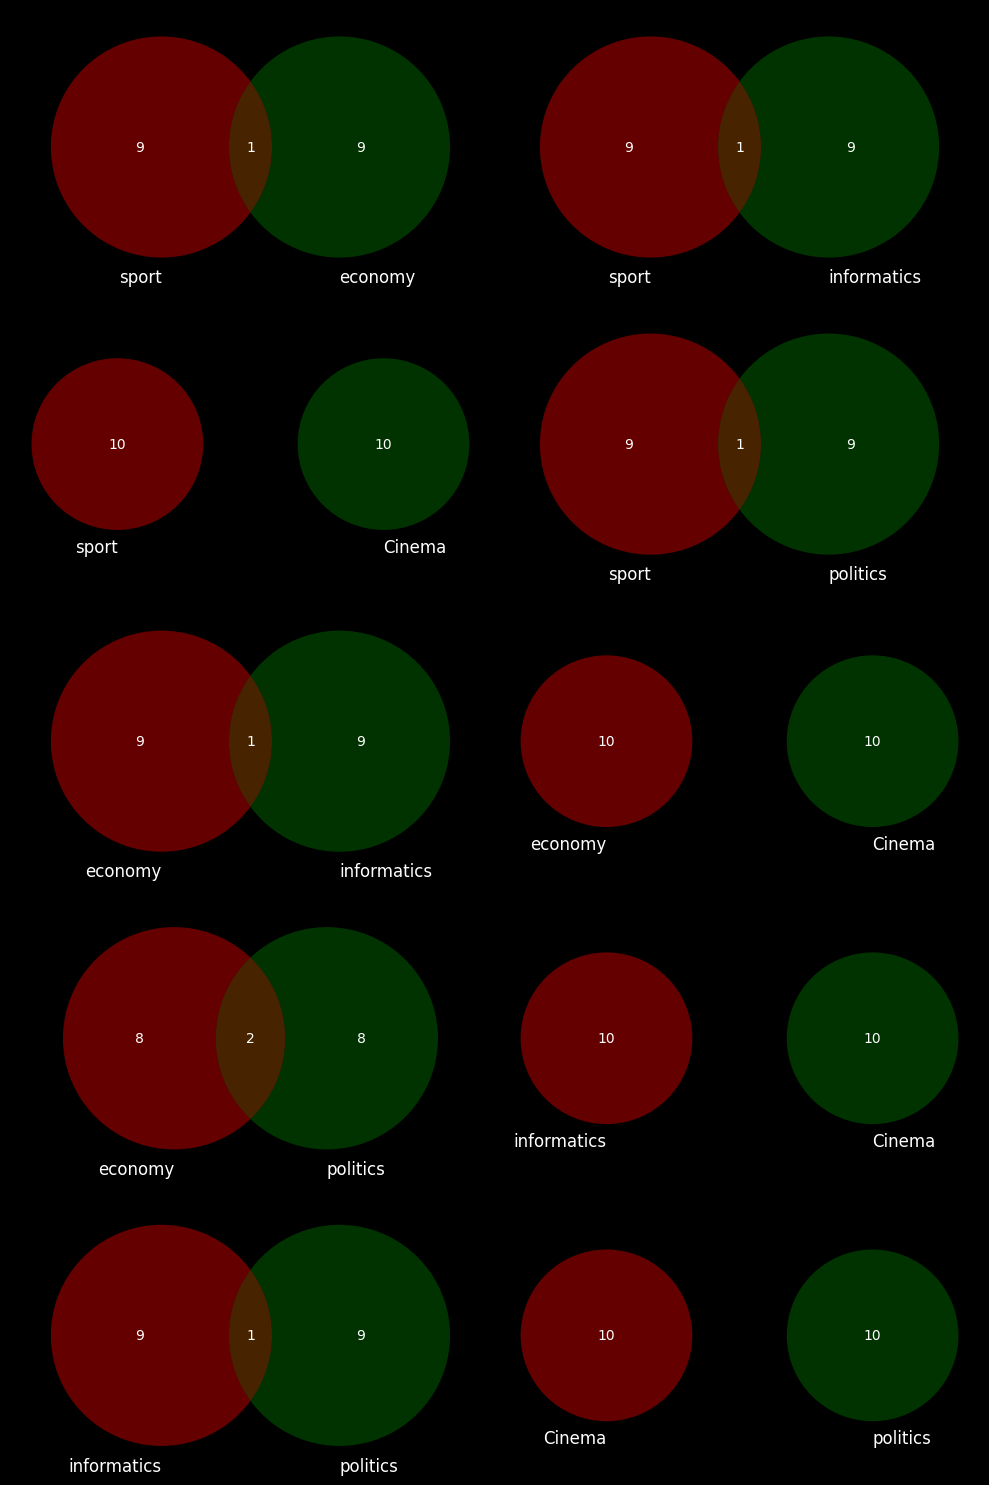

In [26]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

#Les mots les plus communs dans les deux clusters
cluster1 = set(find_top_words(0))
cluster2 = set(find_top_words(1))
cluster3 = set(find_top_words(2))
cluster4 = set(find_top_words(3))
cluster5 = set(find_top_words(4))

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))

venn2([cluster1, cluster2], set_labels=(topicFromWords(find_top_words(0)), topicFromWords(find_top_words(1))), ax=ax[0, 0])
venn2([cluster1, cluster3], set_labels=(topicFromWords(find_top_words(0)), topicFromWords(find_top_words(2))), ax=ax[0, 1])
venn2([cluster1, cluster4], set_labels=(topicFromWords(find_top_words(0)), topicFromWords(find_top_words(3))), ax=ax[1, 0])
venn2([cluster1, cluster5], set_labels=(topicFromWords(find_top_words(0)), topicFromWords(find_top_words(4))), ax=ax[1, 1])
venn2([cluster2, cluster3], set_labels=(topicFromWords(find_top_words(1)), topicFromWords(find_top_words(2))), ax=ax[2, 0])
venn2([cluster2, cluster4], set_labels=(topicFromWords(find_top_words(1)), topicFromWords(find_top_words(3))), ax=ax[2, 1])
venn2([cluster2, cluster5], set_labels=(topicFromWords(find_top_words(1)), topicFromWords(find_top_words(4))), ax=ax[3, 0])
venn2([cluster3, cluster4], set_labels=(topicFromWords(find_top_words(2)), topicFromWords(find_top_words(3))), ax=ax[3, 1])
venn2([cluster3, cluster5], set_labels=(topicFromWords(find_top_words(2)), topicFromWords(find_top_words(4))), ax=ax[4, 0])
venn2([cluster4, cluster5], set_labels=(topicFromWords(find_top_words(3)), topicFromWords(find_top_words(4))), ax=ax[4, 1])

plt.tight_layout()
plt.show()

In [27]:
# SINON DIAGRAMME À 5 DIRECTEMENT MAIS FONCTIONNE PAS POUR MOI 


#from matplotlib_venn import venn5
#import matplotlib.pyplot as plt
#
#cluster1 = set(find_top_words(0))
#cluster2 = set(find_top_words(1))
#cluster3 = set(find_top_words(2))
#cluster4 = set(find_top_words(3))
#cluster5 = set(find_top_words(4))
#
#venn = venn5([cluster1, cluster2, cluster3, cluster4, cluster5])
#plt.show()

In [28]:
df.to_csv("clusterized_df.csv", index=False)

In [29]:
#Visualisation du nombre d'articles par sujet 
df['topic'].value_counts()

economy        897
sport          531
informatics    327
politics       268
Cinema         202
Name: topic, dtype: int64

In [ ]:
# Utilisation de la méthode silhouette_score pour trouver le meilleur nombre de cluster 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['article'])

X1 = X

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    score = silhouette_score(X, kmeans.labels_)
    scores.append(score)

# Tracer l'inertie en fonction du nombre de clusters
plt.plot(scores, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("score")
plt.show()

best_k = np.argmax(scores) + 2
print("Le meilleur nombre de clusters est :", best_k)

On voit que les classes sont assez déséquiilibrés.

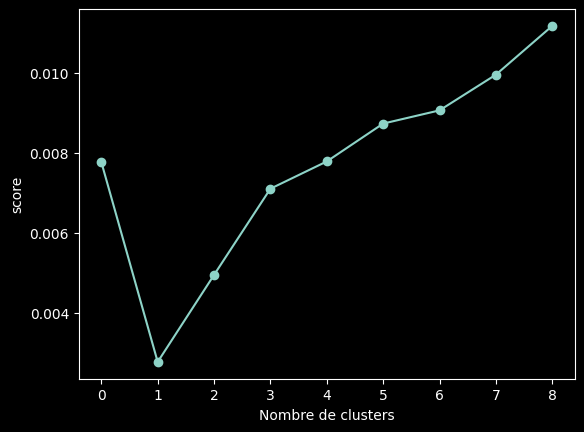

Le meilleur nombre de clusters est : 10


In [31]:
# Utilisation de la méthode silhouette_score pour trouver le meilleur nombre de cluster pour l'algorithme Birch
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
import numpy as np

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['article'])

X1 = X

scores = []
for k in range(2, 11):
    birch = Birch(n_clusters=k).fit(X)
    score = silhouette_score(X, birch.labels_)
    scores.append(score)

# Tracer l'inertie en fonction du nombre de clusters
plt.plot(scores, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("score")
plt.show()

best_k = np.argmax(scores) + 2
print("Le meilleur nombre de clusters est :", best_k)

Cinema
Cinema
entertainment
Cinema
entertainment
sport
Cinema
entertainment
Cinema
entertainment


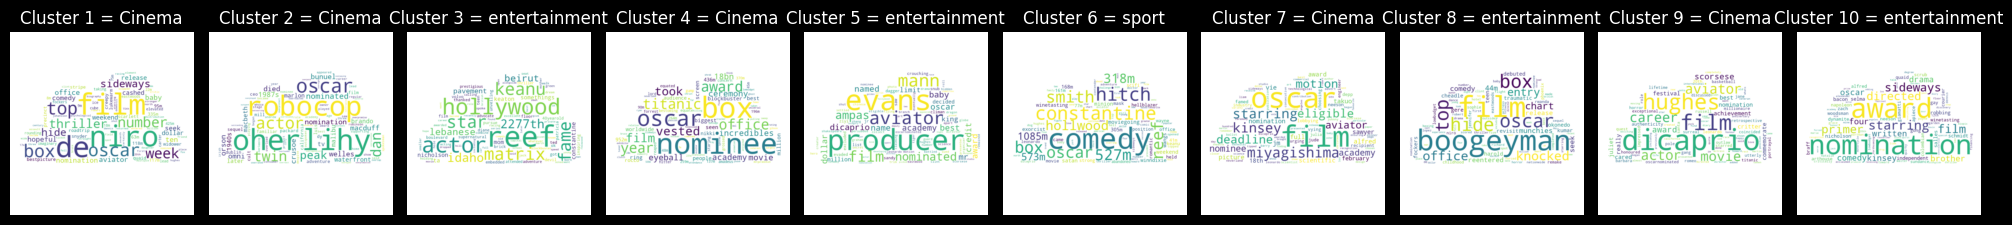

Cluster 1
Top words: ['niro', 'film', 'de', 'oscar', 'top', 'box', 'number', 'week', 'thriller', 'sideways']


Cluster 2
Top words: ['oherlihy', 'robocop', 'oscar', 'actor', 'twin', 'dan', 'peak', 'nominated', 'nomination', 'died']


Cluster 3
Top words: ['reef', 'hollywood', 'actor', 'matrix', 'keanu', 'star', 'fame', '2277th', 'idaho', 'lebanese']


Cluster 4
Top words: ['nominee', 'box', 'oscar', 'titanic', 'office', 'award', 'year', 'vested', 'film', 'took']


Cluster 5
Top words: ['producer', 'evans', 'aviator', 'mann', 'film', 'ampas', 'nominated', 'dicaprio', 'best', 'mr']


Cluster 6
Top words: ['comedy', 'constantine', 'hitch', 'smith', 'reef', 'oscar', 'box', '527m', 'hollwood', '318m']


Cluster 7
Top words: ['film', 'oscar', 'miyagishima', 'starring', 'kinsey', 'eligible', 'deadline', 'motion', 'aviator', 'nominee']


Cluster 8
Top words: ['boogeyman', 'film', 'oscar', 'box', 'top', 'hide', 'knocked', 'office', 'entry', 'chart']


Cluster 9
Top words: ['dicaprio', 'dicaprio

In [32]:
#Clustering avec Birch
best_k = 10
from sklearn.cluster import Birch
df2 = df1.copy()

# Créer un pipeline de traitement des données
vectorizer = TfidfVectorizer()
birch = Birch(n_clusters=best_k)
pipeline = Pipeline([("vectorizer", vectorizer), ("birch", birch)])

# Entraîner le modèle
X = df2['article']
pipeline.fit(X)
df2["cluster"] = birch.labels_

# Extraire les centres des clusters
cluster_centers = birch.subcluster_centers_

# Déterminer le vocabulaire associé à chaque cluster
vocabulary = vectorizer.vocabulary_

clusters_topic = {}
for i in range(best_k): 
    clusters_topic[i] = topicFromWords(find_top_words(i))
    print(clusters_topic[i])

df2["topic"] = df2["cluster"].apply(lambda x: clusters_topic[x])

# Créer un nuage de mots pour chaque cluster
wordclouds = [plot_wordcloud(i) for i in range(birch.n_clusters)]

# Afficher tous les nuages de mots en utilisant matplotlib
plt.figure(figsize=(20, 12))
for i, wordcloud in enumerate(wordclouds):
    plt.subplot(1, birch.n_clusters, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster " + str(i + 1) + " = " + topicFromWords(find_top_words(i)))
plt.tight_layout()
plt.show()

# Afficher les mots les plus pertinents pour chaque cluster
for i in range(birch.n_clusters):
    print("Cluster", i + 1)
    print("Top words:", find_top_words(i))
    print("\n")

Cinema
Cinema
entertainment


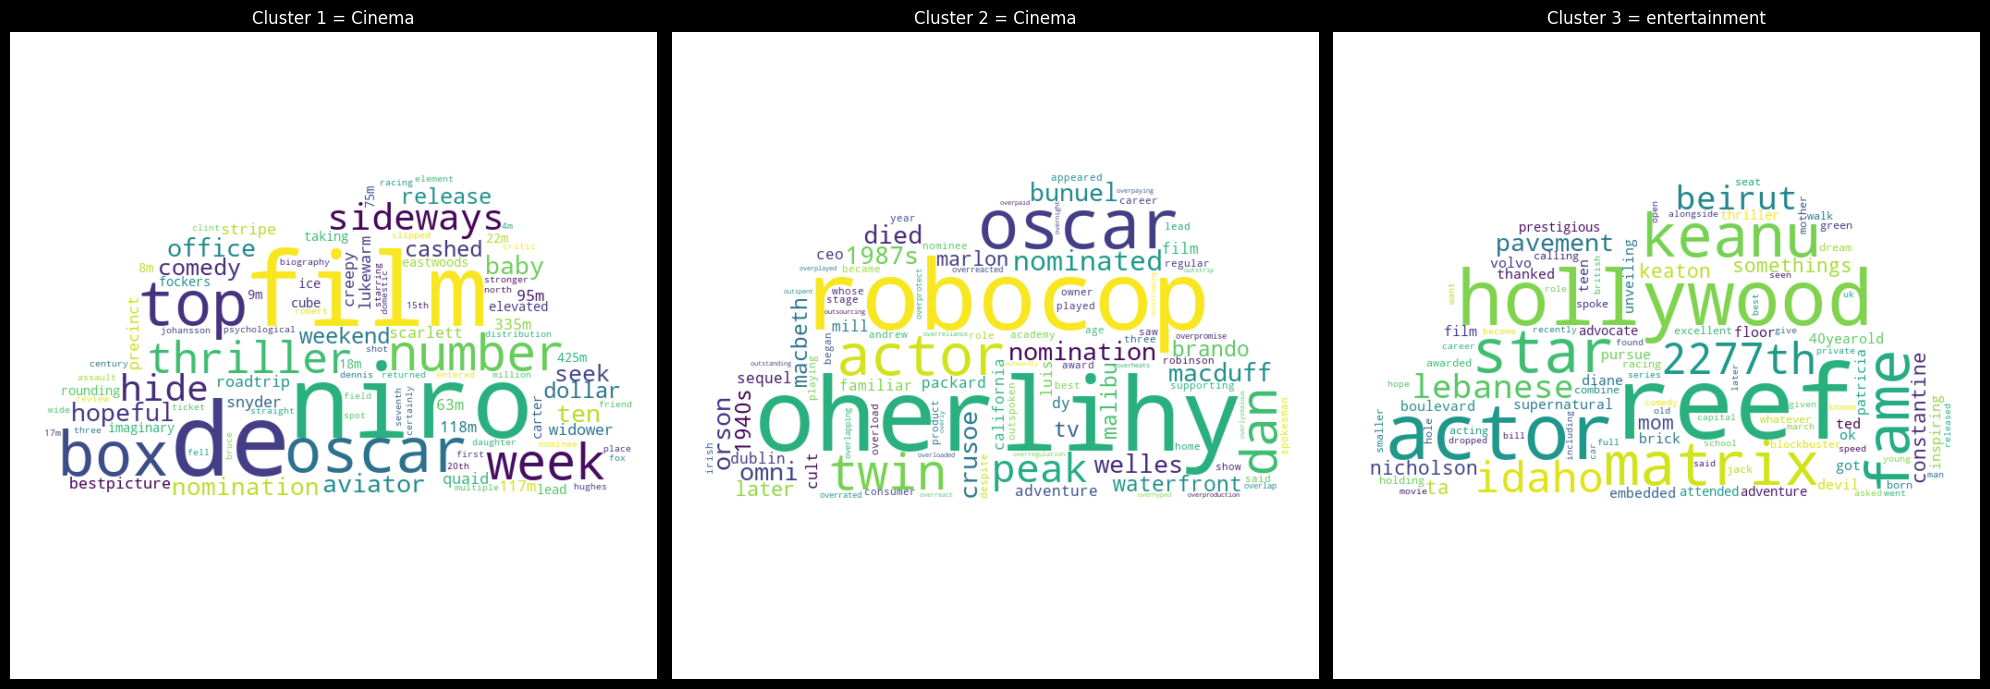

Cluster 1
Top words: ['niro', 'film', 'de', 'oscar', 'top', 'box', 'number', 'week', 'thriller', 'sideways']


Cluster 2
Top words: ['oherlihy', 'robocop', 'oscar', 'actor', 'twin', 'dan', 'peak', 'nominated', 'nomination', 'died']


Cluster 3
Top words: ['reef', 'hollywood', 'actor', 'matrix', 'keanu', 'star', 'fame', '2277th', 'idaho', 'lebanese']




In [33]:
#Clustering avec Birch
best_k = 3
from sklearn.cluster import Birch
df2 = df1.copy()

# Créer un pipeline de traitement des données
vectorizer = TfidfVectorizer()
birch = Birch(n_clusters=best_k)
pipeline = Pipeline([("vectorizer", vectorizer), ("birch", birch)])

# Entraîner le modèle
X = df2['article']
pipeline.fit(X)
df2["cluster"] = birch.labels_

# Extraire les centres des clusters
cluster_centers = birch.subcluster_centers_

# Déterminer le vocabulaire associé à chaque cluster
vocabulary = vectorizer.vocabulary_

clusters_topic = {}
for i in range(best_k): 
    clusters_topic[i] = topicFromWords(find_top_words(i))
    print(clusters_topic[i])

df2["topic"] = df2["cluster"].apply(lambda x: clusters_topic[x])

# Créer un nuage de mots pour chaque cluster
wordclouds = [plot_wordcloud(i) for i in range(birch.n_clusters)]

# Afficher tous les nuages de mots en utilisant matplotlib
plt.figure(figsize=(20, 12))
for i, wordcloud in enumerate(wordclouds):
    plt.subplot(1, birch.n_clusters, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Cluster " + str(i + 1) + " = " + topicFromWords(find_top_words(i)))
plt.tight_layout()
plt.show()

# Afficher les mots les plus pertinents pour chaque cluster
for i in range(birch.n_clusters):
    print("Cluster", i + 1)
    print("Top words:", find_top_words(i))
    print("\n")